## Gaussian Process Regression

Apply Gaussian Process Regression to the Insurance dataset and select hyperparameters via cross-validation. 

Apply Z-score scaling to the features and the target before proceeding to fitting/hyperparameter selection, being sure to avoid data leakage in the process. 


Best Length Scale: 20.0, Best Alpha: 0.2, Mean MSE: 0.15950526708668153
Final MSE: 0.17450880524383555


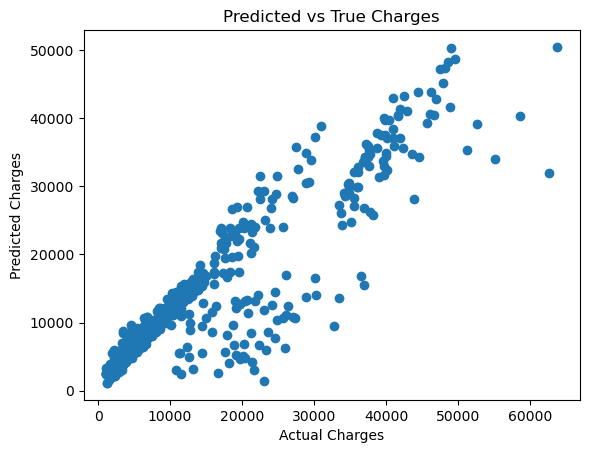

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def z_score_normalize(xs):
    xs = xs.astype(float)
    mean = np.mean(xs, axis=0)
    std_dev = np.std(xs, axis=0)
    xs = (xs - mean) / std_dev
    return xs

# Prepare data
df = pd.read_csv('insurance.csv')
df = pd.get_dummies(df, columns = ['sex', 'smoker', 'region'])
df = df[[col for col in df.columns if col != 'charges'] + ['charges']]

# Split up data
training_set, holdout_set = train_test_split(df, test_size=0.5)

training_arr = training_set.to_numpy()
holdout_arr = holdout_set.to_numpy()
training_xs = training_arr[:, :-1]
training_ys = training_arr[:, -1]

holdout_xs = holdout_arr[:, :-1]
holdout_ys = holdout_arr[:, -1]

length_scales = [1.0, 2.0, 5.0, 10.0, 20.0]
alphas = [0.1, 0.2, 1.0, 2.0, 10.0]

# Separate data into folds
indices = np.arange(len(training_xs))
np.random.shuffle(indices)
folds = np.array_split(indices, 5)

results = []

for ls in length_scales:
    for alpha in alphas:
        kernel = RBF(length_scale=ls,length_scale_bounds=(1e-05, 100000.0))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

        mse_list = []
        # Cross-validation
        for fold in folds: #we're taking this specific fold to be evaluation fold
            mask = np.ones(training_xs.shape[0], dtype=bool)
            mask[fold] = False

            X_train = z_score_normalize(training_xs[mask])
            y_train = z_score_normalize(training_ys[mask])
            
            X_val = z_score_normalize(training_xs[fold])
            y_val = z_score_normalize(training_ys[fold])
            
            gpr.fit(X_train, y_train)
            
            y_val_pred = gpr.predict(X_val)
            mse = np.mean((y_val - y_val_pred)**2)
            mse_list.append(mse)

        # Average MSE across folds
        mean_mse = np.mean(mse_list)
        results.append((ls, alpha, mean_mse))
        
best_params = sorted(results, key=lambda x: x[2])[0]
best_length_scale, best_alpha, best_mse = best_params
print(f"Best Length Scale: {best_length_scale}, Best Alpha: {best_alpha}, Mean MSE: {best_mse}")

final_kernel = RBF(length_scale=best_length_scale)
final_gpr = GaussianProcessRegressor(kernel=final_kernel, alpha=best_alpha, n_restarts_optimizer=10)
final_gpr.fit(z_score_normalize(training_xs), z_score_normalize(training_ys))

holdout_pred = final_gpr.predict(z_score_normalize(holdout_xs))

holdout_ys = holdout_ys.astype(float)
mean = np.mean(holdout_ys, axis=0)
std_dev = np.std(holdout_ys, axis=0)

# Calculate final MSE
final_mse = np.mean((z_score_normalize(holdout_ys) - holdout_pred)**2)

print(f"Final MSE: {final_mse}")
holdout_pred = holdout_pred * std_dev + mean

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Predicted vs True Charges')
plt.scatter(holdout_ys, holdout_pred)
plt.show()